In [1]:
import os

from pdbfixer import PDBFixer
import openmm as mm
from openmm import unit
from openmm import app
import numpy as np
from matplotlib import pyplot as plt
import nglview as nv
from math import sqrt

# Preparing Barnase 

## Obtaining best chain

From barnase-barstar pdb previously analyzed, it was identifed that the "best" barnase chain contain 110 residues and 878 atoms, so the task is to identify it from the 12 chains in the pdb. 

In [2]:
fixer = PDBFixer(filename='1brs.pdb')

In [3]:
fixer.topology

<Topology; 12 chains, 1101 residues, 5151 atoms, 4740 bonds>

In [4]:
fixer.removeChains([0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [5]:
fixer.topology

<Topology; 1 chains, 110 residues, 878 atoms, 899 bonds>

Although manually, the barnase chain was identified.

<div class="alert alert-info">
<strong>Question:</strong> Is there a more efficient way to identify the chain were looking for?
</div>

I don't have an answer now, but there should be a better way. We must keep it in mind. In the future we will try to rewrite these workflows with MolSysMT. This could be a good point to improve the library.

<div class="alert alert-info">
<strong>Question:</strong> How call a list in an object in order to print all the residues?
</div>

Do you mean something like the following?

In [6]:
for chain in fixer.topology.chains():
    for residue in chain.residues():
        if residue.name == 'ALA':
            print(chain.id, chain.index, residue.id, residue.name)

B 0 1 ALA
B 0 11 ALA
B 0 30 ALA
B 0 32 ALA
B 0 37 ALA
B 0 43 ALA
B 0 46 ALA
B 0 74 ALA


In [7]:
for chain in fixer.topology.chains():
    for residue in chain.residues():
            print(chain.id, residue.id, residue.name)

B 1 ALA
B 2 GLN
B 3 VAL
B 4 ILE
B 5 ASN
B 6 THR
B 7 PHE
B 8 ASP
B 9 GLY
B 10 VAL
B 11 ALA
B 12 ASP
B 13 TYR
B 14 LEU
B 15 GLN
B 16 THR
B 17 TYR
B 18 HIS
B 19 LYS
B 20 LEU
B 21 PRO
B 22 ASP
B 23 ASN
B 24 TYR
B 25 ILE
B 26 THR
B 27 LYS
B 28 SER
B 29 GLU
B 30 ALA
B 31 GLN
B 32 ALA
B 33 LEU
B 34 GLY
B 35 TRP
B 36 VAL
B 37 ALA
B 38 SER
B 39 LYS
B 40 GLY
B 41 ASN
B 42 LEU
B 43 ALA
B 44 ASP
B 45 VAL
B 46 ALA
B 47 PRO
B 48 GLY
B 49 LYS
B 50 SER
B 51 ILE
B 52 GLY
B 53 GLY
B 54 ASP
B 55 ILE
B 56 PHE
B 57 SER
B 58 ASN
B 59 ARG
B 60 GLU
B 61 GLY
B 62 LYS
B 63 LEU
B 64 PRO
B 65 GLY
B 66 LYS
B 67 SER
B 68 GLY
B 69 ARG
B 70 THR
B 71 TRP
B 72 ARG
B 73 GLU
B 74 ALA
B 75 ASP
B 76 ILE
B 77 ASN
B 78 TYR
B 79 THR
B 80 SER
B 81 GLY
B 82 PHE
B 83 ARG
B 84 ASN
B 85 SER
B 86 ASP
B 87 ARG
B 88 ILE
B 89 LEU
B 90 TYR
B 91 SER
B 92 SER
B 93 ASP
B 94 TRP
B 95 LEU
B 96 ILE
B 97 TYR
B 98 LYS
B 99 THR
B 100 THR
B 101 ASP
B 102 HIS
B 103 TYR
B 104 GLN
B 105 THR
B 106 PHE
B 107 THR
B 108 LYS
B 109 ILE
B 110 ARG


I don't know why they did like that. The object 'chains' or 'residues' are iterators and not lists:

In [8]:
type(fixer.topology.chains)

method

In [9]:
type(fixer.topology.chains())

list_iterator

A list can be created from an iterator, easy:

In [10]:
chains = list(fixer.topology.chains())

In [11]:
type(chains)

list

In [12]:
chains[0]

<Chain 0>

## Editing

Using PDBFixer, we can add residues, atoms and water molecules to our system.

In [13]:
fixer = PDBFixer(filename='1brs.pdb')
fixer.removeChains([0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [14]:
fixer.findMissingResidues()
missing_residues = fixer.missingResidues
print(f"{len(missing_residues)} missing residues")

fixer.findNonstandardResidues()
nonstandard_residues = fixer.nonstandardResidues
print(f"{len(nonstandard_residues)} non standard residues")

fixer.findMissingAtoms()
missing_atoms = fixer.missingAtoms
missing_terminals = fixer.missingTerminals
print(f"{len(missing_atoms)} missing atoms")
print(f"{len(missing_terminals)} missing terminals")

if len(nonstandard_residues)>0:
    fixer.replaceNonstandardResidues()

if len(missing_atoms)>0:
    fixer.addMissingAtoms()

0 missing residues
0 non standard residues
0 missing atoms
0 missing terminals


Let's see how some aminoacids change when different pH is taken to protonate the system:

In [15]:
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3p.xml')

In [16]:
counter = {'HIP':[], 'HIE':[], 'HID':[]}
pHs = np.linspace(1, 14, 20)

for pH in pHs:
    for residue in counter:
        counter[residue].append(0)
    modeller = app.Modeller(fixer.topology, fixer.positions)
    residues_protonated = modeller.addHydrogens(forcefield=forcefield, pH=pH)
    for residue in residues_protonated:
        if residue is not None:
            counter[residue][-1]+=1

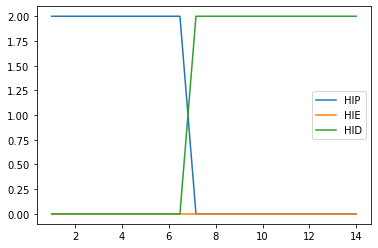

In [17]:
for residue in counter:
    plt.plot(pHs, counter[residue], label=residue)

plt.legend()
plt.show()

In [18]:
for ii in fixer.topology.chains():
    print(ii.index, ii.id)

0 B


In [19]:
ii.id

'B'

Is the protonated states something stationary along the simulation? The protonation state of certain residues depends on their chemical environment. We have here inferred how the histidine residues are protonated at different pHs. But: will this states change along the simulation? How can we define these states without ions and water molecules? Is the chemical environment of a given residue something that will change in time? If the protonated residues can change their state near pH 7, are we worried? Should we protonate after solvation?

We are interested in the interaction between barnase and barstar. Is any of the aminoacids with different possible protonated states in the interface or near?

What value of pH should you use? Are you interested in a simulation of the receptor in pure water? in the cytoplasm? in the nucleous? Is the pH different? Is it relevant?

In [20]:
modeller = app.Modeller(fixer.topology, fixer.positions)

pH = 7.2
residues_protonated = modeller.addHydrogens(forcefield=forcefield, pH=pH)

In [21]:
[residue_name for residue_name in residues_protonated if residue_name is not None]

['HID', 'HID']

Let's see the charge of our system.

In [22]:
# Lets create a system with the protein in vacuum (infinite space) to get the charge

system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.NoCutoff)

charge = 0.0 * unit.elementary_charge
for force_index in range(system.getNumForces()):
    force = system.getForce(force_index)
    if isinstance(force, mm.NonbondedForce):
        for index in range(system.getNumParticles()):
            charge+=force.getParticleParameters(int(index))[0]

charge = np.round(charge._value)*charge.unit

In [23]:
charge

Quantity(value=2.0, unit=elementary charge)

What would be then charge of our protein at pH=6.5? What's the pH of the cell cytoplasm? Is the pH homogeneous in the cell? Are there regions with differen pH? What pH should we choose?

In [24]:
app.PDBFile.writeFile(modeller.topology, modeller.positions, open('barnase.pdb', 'w'))

## Finishing with Modeller

In order to build a system with an specific water model and box shape, Modeller is a great tool.

In [25]:
pdb = app.PDBFile('barnase.pdb')

In [26]:
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3p.xml')

In [27]:
modeller = app.Modeller(pdb.topology, pdb.positions)

In [28]:
modeller.addSolvent(forcefield, model='tip3p')

In [29]:
app.PDBFile.writeFile(modeller.topology, modeller.positions, open('brns-solv.pdb', 'w'))

Did we add ions? What's the charge of the solvated system?

In the README.md file there were some indications about how barnase had to be solvated. Did you follow them? Is the box a truncated octahedral box with the protein in the center and the limits of the box 14 angstroms away from the protein surface (at least)?

Could you show with NGLView the water box?

In [30]:
modeller.topology

<Topology; 3 chains, 23264 residues, 71185 atoms, 48052 bonds>

In [31]:
view = nv.show_file('brns-solv.pdb')
view.add_licorice(selection='water')
view

NGLWidget()

## Diferent water-boxes

### Cubic

In [32]:
pdb = app.PDBFile('barnase.pdb')

In [33]:
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3p.xml')

In [34]:
modeller = app.Modeller(pdb.topology, pdb.positions)

In [35]:
geompadding = 1.4 * unit.nanometers
maxSize = max(max((pos[i] for pos in pdb.positions))-min((pos[i] for pos in pdb.positions)) for i in range(3))
vectors = mm.Vec3(1,0,0), mm.Vec3(0,1,0), mm.Vec3(0,0,1)
boxVectors = [(maxSize+geompadding)*v for v in vectors]

In [36]:
modeller.addSolvent(forcefield, model='tip3p', boxVectors=boxVectors)

In [37]:
app.PDBFile.writeFile(modeller.topology, modeller.positions, open('brns-cubic.pdb', 'w'))

In [38]:
view = nv.show_file('brns-cubic.pdb')
view.add_licorice(selection='water')
view

NGLWidget()

### Truncated Octahedral

In [39]:
pdb = app.PDBFile('barnase.pdb')
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3p.xml')
modeller = app.Modeller(pdb.topology, pdb.positions)

In [40]:
geompadding = 1.4 * unit.nanometers
maxSize = max(max((pos[i] for pos in pdb.positions))-min((pos[i] for pos in pdb.positions)) for i in range(3))
vectors = mm.Vec3(1,0,0), mm.Vec3(1/3,2*sqrt(2)/3,0), mm.Vec3(-1/3,sqrt(2)/3,sqrt(6)/3)
boxVectors = [(maxSize+geompadding)*v for v in vectors]

In [41]:
modeller.addSolvent(forcefield, model='tip3p', boxVectors=boxVectors)

In [42]:
app.PDBFile.writeFile(modeller.topology, modeller.positions, open('brns-oct.pdb', 'w'))

In [43]:
view = nv.show_file('brns-oct.pdb')
view.add_licorice(selection='water')
view

NGLWidget()

### Rhombic Dodecahedral

In [44]:
pdb = app.PDBFile('barnase.pdb')
forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3p.xml')
modeller = app.Modeller(pdb.topology, pdb.positions)

In [45]:
geompadding = 1.4 * unit.nanometers
maxSize = max(max((pos[i] for pos in pdb.positions))-min((pos[i] for pos in pdb.positions)) for i in range(3))
vectors = mm.Vec3(1,0,0), mm.Vec3(0,1,0), mm.Vec3(0.5,0.5,sqrt(2)/2)
boxVectors = [(maxSize+geompadding)*v for v in vectors]

In [46]:
modeller.addSolvent(forcefield, model='tip3p', boxVectors=boxVectors)

In [47]:
app.PDBFile.writeFile(modeller.topology, modeller.positions, open('brns-dode.pdb', 'w'))

In [48]:
view = nv.show_file('brns-dode.pdb')
view.add_licorice(selection='water')
view

NGLWidget()